#### THIS NOTEBOOK DEMONSTRATES HOW TO USE THE <a href="https://github.com/naplab/DSTRF">dSTRF</a> TOOLBOX ON A SAMPLE DATASET

# Setup

In [1]:
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
from hdf5storage import loadmat

import torch
import torchaudio
import pytorch_lightning as pl

import dynamic_strf.modeling as modeling
import dynamic_strf.estimate as estimate
import dynamic_strf.visualize as visualize

device = torch.device('cuda:0')

# Data preparation

We first load the audio stimuli and neural response data from disk. A spectrogram parser class which uses torchaudio to obtain log-power Mel-spectrograms is included in the `modeling` module of the package. After preprocessing, the stimuli should be a list of $N$ trials, where the $i$-th trial is a tensor of shape $[time_i \times in\_channels]$; and the response should be list of $N$ trials, where the $i$-th trial is a tensor of shape $[time_i \times out\_channels]$. In this case $in\_channels$ is the number of frequency bins of the spectrogram, and $out\_channels$ is the number of electrodes from the neural recording.

Note that in this example `f_max` is set to 11025/2 because the sampling rate of the audio recording was 11025Hz, and according to the Nyquist theorem only the information up to half the sampling rate is preserved.

In [2]:
spect_cfg = dict(
    out_sr = 100,
    freqbins = 64,
    f_max = 11025/2
)

X = []
for i in range(18):
    sound, in_sr = torchaudio.load(f'data/Sounds/stim{i+1}.flac')
    spect = modeling.SpectrogramParser(in_sr, **spect_cfg)(sound)
    X.append(spect)

Y = []
path_fmt = 'data/LIJ%s_data_TrainOn1If2Records.mat'
for subj_id in ['109', '110', '112', '113', '114', '120']:
    Y.append(loadmat(path_fmt % subj_id)['noisy_resp'].squeeze(0))
Y = [torch.cat([torch.from_numpy(y[i]) for y in Y], dim=1) for i in range(18)]

for i in range(18):
    diff = len(X[i]) - len(Y[i])
    if diff == 1:
        X[i] = X[i][:-1]
    elif diff:
        raise RuntimeError(f'X and Y have different lengths for stim{i+1}!')
    
    X[i] = X[i][100:-50].float()
    Y[i] = Y[i][100:-50].float()

channels = Y[0].shape[1]

The example data consists of 18 trials, totalling about 15 minutes:

In [3]:
print(f'Number of trials: {len(X)}')
print(f'First two trials of X: {list(X[0].shape)} , {list(X[1].shape)}')
print(f'First two trials of Y: {list(Y[0].shape)}, {list(Y[1].shape)}')

Number of trials: 18
First two trials of X: [6047, 64] , [5053, 64]
First two trials of Y: [6047, 220], [5053, 220]


This is what the stimulus spectrogram looks like for the first 2 seconds of the first trial:

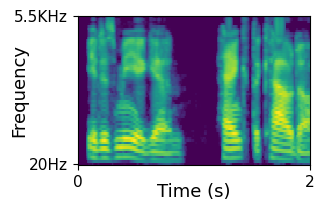

In [4]:
plt.figure(figsize=(3, 2))
plt.imshow(X[0][:200].T, origin='lower', aspect=2, interpolation='none', )
plt.xlabel('Time (s)', fontsize=13, labelpad=-5)
plt.xticks([0, 200], [0, 2], fontsize=11)
plt.ylabel('Frequency', fontsize=13, labelpad=-10)
plt.yticks([0, 64], ['20Hz', '5.5KHz'], fontsize=11)
plt.show()

This is what the neural activity looks like for the same period of time:

Neural responses of first 2 seconds of data:


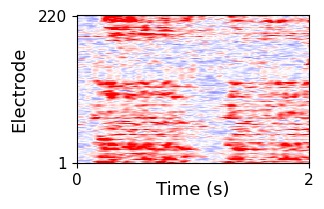

In [5]:
print('Neural responses of first 2 seconds of data:')
plt.figure(figsize=(3, 2))
plt.imshow(Y[0][:200].T, origin='lower', aspect=0.58,
           cmap='bwr', vmin=-5, vmax=5, interpolation='none')
plt.xlabel('Time (s)', fontsize=13, labelpad=-5)
plt.xticks([0, 200], [0, 2], fontsize=11)
plt.ylabel('Electrode', fontsize=13, labelpad=7)
plt.yticks([0, 219], [1, 220], fontsize=11)
plt.show()

# Analysis robustness

This toolbox comes with a simple function (`fit_multiple`) that utilizes `pytorch-lightning` to train encoding models that map the stimulus to the response. This function includes support for:

1. ***Cross-validation***: In this case, assuming $N$ total trials, $N$ models are trained, where the $i$-th model is trained by leaving out the $i$-th trial from the data. It is not recommended to use the dSTRF analysis of a model on the same data that it was trained on, especially when we don't have enough data to avoid potential overfitting. The cross-validated training allows us to analyze the model on the entire data, such that when analyzing trial $i$, we use the $i$-th model which was trained on all trials except the $i$-th one. Note that enabling cross-validation increases training time by a factor of $N$.

2. ***Data jackknifing***: In this case, assuming $N$ **training** trials, $N$ models are trained, where the $i$-th model is trained by leaving out the $i$-th trial from the data, similar to above. The difference is, in this case the goal is to achieve a robust model and estimate reliability of model predictions. So, when predicting jackknifed neural responses, we predict the response to **validation** trial(s) using all jackknifed models, then average the predictions. Similarly, when computing the dSTRFs, we compute the dSTRF of each jackknifed model, and average the dSTRFs. Note that since a dSTRF denotes a locally linear relation between the stimulus and response, the jackknife-averaged dSTRF will produce the jackknife-averaged predictions described above. Also note that enabling data jackknifing increases training time by a factor of $N$.

3. ***Cross-validated jackknifing***: When enabling both options above, assuming $N$ total trials, $N(N-1)/2$ models are trained, where each time 2 trials are left out from training. When evaluating predictions or dSTRFs for a trial $i$, all models that included trial $i$ in their leave-out pair are considered. This means for each trial $i$, there are exactly $N-1$ models that have not seen this trial, i.e., models with leave-out pairs $(1,i)$, $(2,i)$, ..., $(i-1,i)$, $(i,i+1)$, $(i,N)$. Note that enabling both cross-validation and data jackknifing increases training time by a factor of $N(N-1)/2$.

The choice to use either of these options depends on the user. If the training data is large enough considering the model size such that overfitting can be safely avoided, then there is a lesser need for jackknifing. However, jackknifing can still be beneficial given the stochastic nature of training neural networks. As for cross-validation, it is only necessary when there is no clear separation between training and validation data. If the behavior of the model is being studied only in specific cases and there is a larger generic training data available, then there is no need for cross-validation.

It is possible to use cross-validated and/or jackknifed analysis on models that have been trained independent of this toolbox. You need to simply save each trained model's pytorch state dictionary (`state_dict`) using the naming convention used by the toolbox, and for analysis provide the list of model paths or the path to the directory where all models are stored:

1. A model trained on all data: `model-all.pt`.

2. A model trained by leaving out trial $i$: `model-{i:03d}.pt`.

3. A model trained by leaving out trials $i$ and $j$: `model-{i:03d}_{j:03d}.pt`.

4. ...

# Training configuration

The provided `fit_multiple` function takes in:
* `builder`: a function that should initialize and return a model to be trained.
* `data`: a pair (X, Y) of stimulus and response trials, as described earlier in the notebook.
* `crossval` and `jackknife`: boolean values indicating leave-out behavior during training.
* `trainer`: a dictionary, or a function that returns an object with method `fit` used to train each model.
* `save_dir`: path to directory to store trained model state dictionaries (cannot be empty).
* `batch_size`: number of trials to backpropagate simultaneously.
* `num_workers`: number of CPU workers to use for fetching and preprocessing data.

### `trainer`

If `trainer` is not set, a default `pl.Trainer` is used for training. If `trainer` is a dictionary, the contents of that dictionary are used to override the initialization parameters of the default `pl.Trainer`:

In [6]:
trainer = {
    'gpus': 1,
    'precision': 16,
    'gradient_clip_val': 10.0,
    'max_epochs': 1000,
    'logger': False,
    'detect_anomaly': True,
    'enable_model_summary': False,
    'enable_progress_bar': True,
    'enable_checkpointing': False
}

Otherwise, trainer should return an object with a `fit` method that can handle the following call:

`trainer.fit(model, dataloader)`

For example:

In [7]:
def trainer():
    return pl.Trainer(
        gpus = 1,
        precision = 16,
        gradient_clip_val = 10.0,
        max_epochs = 1000,
        logger = False,
        detect_anomaly = True,
        enable_model_summary = False,
        enable_progress_bar = True,
        enable_checkpointing = False,
    )

### `builder`

The model returned by builder should be a pytorch module, i.e., a subclass of `torch.nn.Module`. Additionally, if using a `pl.Trainer` trainer (default), the returned model should be a subclass  of `pl.LightningModule`, which is in turn a subclass of `torch.nn.Module` with a few extra methods that handle optimizer initialization, loss calculation, etc. It is quite easy to convert a torch module to a lightning module (<a href="https://www.pytorchlightning.ai/tutorials">tutorials</a>).

Two sample model classes are defined in the ***modeling*** module:

#### 1. Linear (STRF)

In [8]:
def builder():
    return modeling.LinearEncoder(
        input_size=spect_cfg['freqbins'],
        channels=channels,
    ).to(device)

#### 2. Deep Convolutional

In [9]:
def builder():
    return modeling.DeepEncoder(
        input_size=spect_cfg['freqbins'],
        hidden_size=128,
        channels=channels,
    ).to(device)

Both models are lightning modules and have been set up with mean square error (MSE) as loss criterion, the RAdam optimizer, and an exponential learning rate decay scheduler. Both model initializers take parameters `optimizer` and `scheduler`, which can be used to override the default optimizer and scheduler.

These parameters can either be dictionaries, which will override the initialization parameters of the default `RAdam` optimizer and `ExponentialLR` scheduler:

In [10]:
optimizer = {'lr': 0.003, 'weight_decay': 0.03}
scheduler = {'gamma': 0.996}

Or functions that initialize and return a pytorch optimizer and scheduler, respectively:

In [11]:
def optimizer(params):
    return torch.optim.AdamW(
        params,
        lr=0.003,
        weight_decay=0.03
    )

def scheduler(optimizer):
    return torch.optim.lr_scheduler.ExponentialLR(
        optimizer,
        gamma=0.996
    )

To optimize the training hyper parameters before committing to a long training session, you can use the simpler function `modeling.fit`, that takes already initialized model and trainer objects and fits a single model.

# Training

Training all necessary models, be it $1$, $N$, or $N(N-1)/2$ models, is achieved by calling `fit_multiple`. Here is an example of training using both cross-validation and jackknifing:

In [12]:
modeling.fit_multiple(
    builder=builder,
    data=(X, Y),
    crossval=True,
    jackknife=True,
    trainer=trainer,
    save_dir='output/5x128-jackknife-cv',
    verbose=0
);

Calling this function will train models and store their state dictionaries in the specified `save_dir` directory, following the naming format explained <a href="#Analysis-robustness">above</a>. To use pretrained models, rename them into this naming format and place them in a directory (or make a list of paths to their locations).

# Evaluation

To evaluate the performance of trainend models, the `test_multiple` function is provided, which supports both cross-validated and jackknifed evaluation. It takes in arguments:
* `model`: an already initialized model.
* `checkpoints`: a list of saved model paths or the path to a directory containing saved models.
* `data`: a pair (X, Y) of stimulus and response trials.
* `crossval`: whether the provided data is the same as training data. If yes, the performance on trial $i$ is only evaluated using models not trained on trial $i$; if false all models are used.
* `jackknife_mode`: when jackknifing, whether to first compute the score for each jackknife instance then average scores (`jackknife_mode='score'`), or to first average predictions of all jackknife isntances then compute score on the average prediction (`jackknife_mode='pred'`). The latter is recommended if analyzing jackknifed predictions and jackknifed dSTRFs.

The jackknifing feature is implicit in the model list. If after leaving out models trained on the cross-validation trial (if `crossval` enabled), there are multiple models left in `checkpoints`, jackknifing is assumed to be used. If only one model remains, no jackknifing is assumed.

Currently, only correlation scoring is supported, i.e., the score is defined as the Pearson correlation between the model prediction and the neural response.

Scores are computed independently for each trial. The function returns a $[N \times out\_channels]$ matrix of scores, where $N$ is the number of trials and $out\_channels$ is the number of electrodes from the neural recording:

In [13]:
scores = modeling.test_multiple(
    model=builder(),
    checkpoints='output/5x128-jackknife-cv',
    data=(X[:1], Y[:1]),
    crossval=True,
    jackknife_mode='pred'
)

There is a similar function `infer_multiple` that takes in similar arguments, with the exception that data is only a list of stimulus trials (response not needed in prediction) and returns a list of $N$ response matrices, each of shape $[time \times out\_channels]$:

In [14]:
preds = modeling.infer_multiple(
    model=builder(),
    checkpoints='output/5x128-jackknife-cv',
    data=X[:1],
    crossval=True
)

# Estimating dSTRFs

To estimate the dynamic spectrotemporal receptive field (dSTRF) of a model on some data, we need to use the `dSTRF_multiple` function. This function takes in similar arguments as `infer_multiple` with the difference of:
* `save_dir`: the location of the directory where the calculated dSTRFs are to be saved.
* `chunk_size`: the number of time points at a time to compute the dSTRFs for. Reduce if running out of GPU memory when calculating dSTRFs.

The dSTRFs for each trial are saved in a separate torch (.pt) file. If cross-validation enabled, the dSTRFs of trial $i$ are calculated only from models that did not see that trial during training. If implicit jackknifing enabled (check <a href="#Evaluation">above</a>), dSTRFs are calculated independently for each model, then resulting dSTRFs are averaged before saving to file.

The dSTRF tensor saved in each file is of shape $[time \times out\_channels \times time\_lag \times in\_channels]$, where $time\_lag$ is the size of the temporal receptive field of the model, i.e., the theoretical window of input that can influence the output. The model object given to the dSTRF estimation functions should have a property called `receptive_field` that denotes this receptive field size. Currently, only causal dSTRFs are supported. If a model is noncausal, the noncausal parts of the dSTRF will be dropped.

In [15]:
estimate.dSTRF_multiple(
    model=builder(),
    checkpoints='output/5x128-jackknife-cv',
    data=X[:1],
    crossval=True,
    save_dir='output/5x128-jackknife-cv-dstrf',
    chunk_size=100
)

Keep in mind that depending on data length, number of output channels, model receptive field, and spectrogram frequency bins, the size of the dSTRF tensor can easily grow quite large (tens of gigabytes). To save space, all dSTRFs are converted to half-precision (16-bit) for storage.

There is extra option to mask the less reliable time-frequency bins of the dSTRF tensors based on their sign consistency across jackknifes. For example, let's assume we have $N$ jackknifed models, and $w_i[t,c,l,f]$ represents the dSTRF value at time sample $t$, for channel $c$, at temporal lag $l$ and frequency bin $f$, for model $i$. Also assume that $\bar{w}[t,c,l,f]$ is the average of $w_i[t,c,l,f]$ across $i$.

Now we can set a sign-consistency threshold $q$ (parameter `filter_q`), such that $\bar{w}[t,c,l,f]$ is assumed to be consistent if the top $q$-th quantile of $w_i[t,c,l,f]$ across $i$ are all positive, or the bottom $q$-th quantile are all negative. All elements of $\bar{w}$ that are NOT sign-consistent are masked (set to zero).

Note that `filter_q` should either be 0, indicating no masking, or a value between 0.5 and 1, indicating masking. Values between 0 and 0.5 are not allowed, since they are equivalent to no masking.

# Visualizing dSTRFs

There are two main ways to visualize the dSTRFs:

#### 1. Static image

We can visualize the dSTRFs of output channel $c$ at times $t_i$ as a static image, just like an STRF:

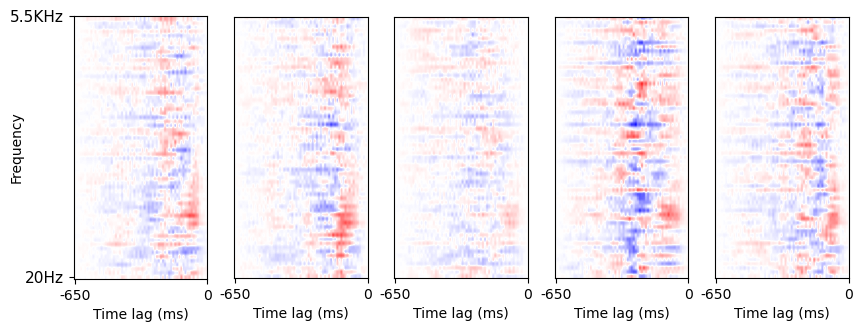

In [16]:
# Load dSTRF, select only channel 10, and convert to 32-bit float
dstrf = torch.load('output/5x128-jackknife-cv-dstrf/dSTRF-000.pt')
dstrf = dstrf[:,10].float()

# Find maximum value for color axis
vmax = dstrf.abs().max(dim=1)[0].max(dim=1)[0].quantile(0.90)

# Plot figure
plt.figure(figsize=(10, 4))
for i, t in enumerate([1000, 1200, 1400, 1600, 1800]):
    plt.subplot(1, 5, i+1)
    plt.imshow(
        dstrf[t].T, aspect=2, cmap='bwr', vmin=-vmax, vmax=vmax, origin='lower'
    )
    
    plt.xlabel('Time lag (ms)')
    plt.xticks([0, 65], [-650, 0])
    if i == 0:
        plt.ylabel('Frequency', labelpad=-10)
        plt.yticks([0, 64], ['20Hz', '5.5KHz'], fontsize=11)
    else:
        plt.yticks([])
plt.show()
del dstrf

#### 2. Dynamic animation

Sometimes a more useful visualization of the dSTRFs of output channel $c$ is as a dynamically animated video of dSTRFs changing with the stimulus from $t_1$ to $t_4$. The function `visualize.dSTRF` takes the path to a dSTRF file and for each channel, generates an animated video of the dSTRFs for all the time duration of the dSTRF tensor (first dimension), and stores it to disk as an "mp4" video. Python slices can be used to limit the range of channels and time to include in the videos. Note that this function uses a python ffmpeg wrapper to generate the videos.

In [17]:
visualize.dSTRF(
    'output/5x128-jackknife-cv-dstrf/dSTRF-000.pt',
    channels=slice(10, 11),
    time_range=slice(1000, 2000),
    output_prefix='output/video/',
    xlabel='Time lag (ms)',
    xticks=[0, 65],
    xtick_labels=[-650, 0],
    ylabel='Frequency',
    yticks=[0, 64],
    ytick_labels=['20Hz', '5.5KHz']
)

In [18]:
ipd.display(ipd.Video('output/video/channel-0000.mp4', height=300))

Here is an example video from the same channel and time range, for the masked dSTRFs ($q=0.75$) calculated above:

In [19]:
visualize.dSTRF(
    'output/5x128-jackknife-cv-dstrf-masked/dSTRF-000.pt',
    channels=slice(10, 11),
    time_range=slice(1000, 2000),
    output_prefix='output/video/masked-',
    xlabel='Time lag (ms)',
    xticks=[0, 65],
    xtick_labels=[-650, 0],
    ylabel='Frequency',
    yticks=[0, 64],
    ytick_labels=['20Hz', '5.5KHz']
)

In [20]:
ipd.display(ipd.Video('output/video/masked-channel-0000.mp4', height=300))

# Estimating dSTRF nonlinearities

Since the dynamics of dSTRFs capture the nonlinear properties of the model being analyzed, we can quantify different types of behaviors of dSTRFs that tend to repeat. The four noonlinear characteristics that we have defined in our research paper, can be computed by calling the `estimate.nonlinearities` function with the path to the dSTRF directory. This function returns a dictionary of the four nonlinear characteristics:
* ***complexity***: the overall variation of dSTRFs.
* ***gain change***: how much the amplitude of the dSTRF changes across the stimulus duration.
* ***temporal hold***: how long does the model keep responding to an event that occured at an earlier time point.
* ***shape change***: how much does the spectrotemporal shape of the dSTRF filter change, ignoring temporal shifts.

Different output channels are analyzed independent of each other, so there will be one value per channel. If there are dSTRFs for multiple trials in the specified directory, this function quantifies each nonlinearity independently for each trial, then applies `reduction` across trials. `reduction` can be `'mean'`, `'median'`, or `'none'`.

In [ ]:
nonlin = estimate.nonlinearities(
    paths=['output/5x128-jackknife-cv-dstrf/dSTRF-000.pt'],
    reduction='mean',
    device=device
)